## Neo4j Graph Database Schema

본 기술구현을 위해 구축한 Knowledge Graph의 노드(Label)와 관계(Relationship) 를 정의합니다

### 1. Nodes (Labels)

| Label | 설명 (Description) | 주요 속성 (Properties) |
| :--- | :--- | :--- |
| **Provider** | 서비스 제공자 (예: KT) | `provider_id`, `name` |
| **Product** | 크롤링 된 구독 상품 (예: 티빙+스타벅스) | `product_id`, `name`, `url`, `fetched_at`, `promotion_info` |
| **Service** | 상품에 포함된 개별 서비스 (예: TVING, 메가커피) | `service_id`, `name`, `category` (OTT, COFFEE 등) |
| **Plan** | 상품의 구체적인 요금제 옵션 (예: 티빙 베이직+메가커피) | `plan_id`, `title`, `price_regular`, `price_kt`, `price_promo`, `currency`, `billing_period` |
| **BasePlan** | 요금제의 기준 키 (동일 계열 요금제 그룹핑) | `key` (예: tving_basic) |
| **Content** | 텍스트 데이터 노드 (혜택 상세 및 유의사항 청크) | `content_id`, `type` ('BENEFIT' or 'POLICY'), `text` (or `detail`), `name` |

---

### 2. Relationships

각 노드 간의 연결 관계를 정의합니다.

| Source Node | Relationship Type | Target Node | 설명 | 속성 (Properties) |
| :--- | :---: | :--- | :--- | :--- |
| **Provider** | `[:PROVIDES]` | **Product** | 제공자가 특정 상품을 제공함 | - |
| **Product** | `[:INCLUDES_SERVICE]` | **Service** | 상품이 특정 서비스(OTT 등)를 포함함 | - |
| **Product** | `[:HAS_PLAN]` | **Plan** | 상품에 속한 구독 요금제 옵션들 | - |
| **Product** | `[:HAS_POLICY]` | **Content** | 상품의 이용약관/유의사항 청크 | - |
| **Plan** | `[:BASED_ON]` | **BasePlan** | 요금제가 특정 기준(Base)을 따름 | - |
| **Plan** | `[:OFFERS]` | **Content** | 요금제가 특정 혜택(Benefit)을 제공함 | `detail` (혜택 상세 내용) |



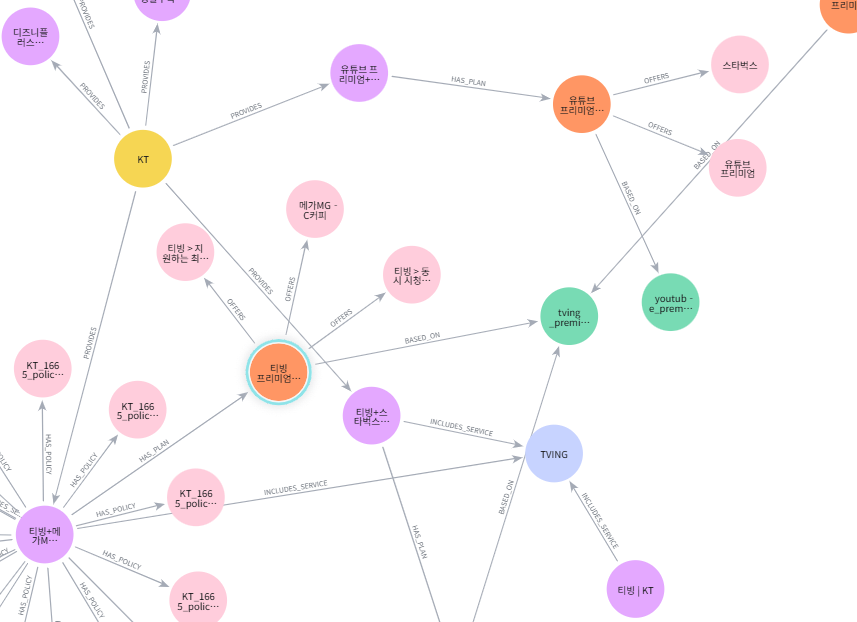

In [ ]:
from IPython.display import Image
Image("visualisation.png")

-> 생성한 db 일부

In [ ]:
!pip install neo4j python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
from neo4j import GraphDatabase, basic_auth
import json
import glob

In [ ]:
#db 초기화를 위한 노드/관계, 인덱스, 제약조건 삭제
def clear_database_and_schema(driver, database="neo4j"):
    with driver.session(database=database) as session:
        session.run("MATCH (n) DETACH DELETE n")
        print("노드+관계 삭제 완료")

        constraints = session.run("""
            SHOW CONSTRAINTS YIELD name
            RETURN name
        """).value()

        for c in constraints:
            session.run(f"DROP CONSTRAINT {c} IF EXISTS")
        print("제약조건 삭제 완료")

        indexes = session.run("""
            SHOW INDEXES YIELD name
            RETURN name
        """).value()
        print("index  삭제 완료")

        for idx in indexes:
            session.run(f"DROP INDEX {idx} IF EXISTS")

        print("[OK] 모두 삭제 완료")

# 제약조건 생성을 위한 함수
def create_constraints(driver, database="neo4j"):
    queries = [
        "CREATE CONSTRAINT provider_id IF NOT EXISTS FOR (p:Provider) REQUIRE p.provider_id IS UNIQUE",
        "CREATE CONSTRAINT product_id  IF NOT EXISTS FOR (p:Product)  REQUIRE p.product_id IS UNIQUE",
        "CREATE CONSTRAINT service_id  IF NOT EXISTS FOR (s:Service)  REQUIRE s.service_id IS UNIQUE",
        "CREATE CONSTRAINT plan_key    IF NOT EXISTS FOR (p:Plan)     REQUIRE p.plan_id IS UNIQUE",
        "CREATE CONSTRAINT content_id  IF NOT EXISTS FOR (c:Content)  REQUIRE c.content_id IS UNIQUE",
        "CREATE CONSTRAINT baseplan_key IF NOT EXISTS FOR (b:BasePlan) REQUIRE b.key IS UNIQUE"
    ]
    with driver.session(database=database) as session:
        for q in queries:
            session.run(q)

In [ ]:
# 1. Provider & Product 생성
def create_provider_product(tx, data):
    provider = data['provider']
    product = data['product']

    promo = data.get('promotion', {})
    promo_status = promo.get('status', 'UNKNOWN')

    join_period = promo.get('join_period_text') or promo.get('join_period')
    if isinstance(join_period, dict):
        period_str = f"{join_period.get('start', '')} ~ {join_period.get('end', '')}"
    else:
        period_str = str(join_period) if join_period else "상시 가입"

    promo_summary = f"상태: {promo_status}, 기간: {period_str}"

    query = """
    MERGE (pv:Provider {provider_id: $provider_id})
    SET pv.name = $provider_name

    MERGE (pd:Product {product_id: $product_id})
    SET pd.name = $product_name,
        pd.url = $product_url,
        pd.fetched_at = $fetched_at,
        pd.promotion_info = $promo_summary

    MERGE (pv)-[:PROVIDES]->(pd)
    """
    tx.run(query,
           provider_id=provider['provider_id'], provider_name=provider['name'],
           product_id=product['product_id'], product_name=product['name'],
           product_url=product['url'], fetched_at=product['fetched_at'],
           promo_summary=promo_summary)

# 2. Service 생성
def create_service(tx, data):
    product_id = data['product']['product_id']
    for svc in data.get('services', []):
        query = """
        MATCH (pd:Product {product_id: $product_id})
        MERGE (s:Service {service_id: $service_id})
        SET s.name = $name, s.category = $category
        MERGE (pd)-[:INCLUDES_SERVICE]->(s)
        """
        tx.run(query, product_id=product_id, service_id=svc['service_id'],
               name=svc['name'], category=svc['category'])

# 3. Plan 및 BasePlan 생성 (Prices 객체 처리 수정)
def create_plans_and_baseplan(tx, data):
    product_id = data['product']['product_id']

    for plan in data.get('subscribe_options', []):
        base_key = plan.get('base_plan_key', 'unknown')

        prices = plan.get('prices', {})

        query = """
        MATCH (pd:Product {product_id: $product_id})

        MERGE (bp:BasePlan {key: $base_plan_key})

        MERGE (pl:Plan {plan_id: $plan_id})
        SET pl.title = $plan_title,
            pl.price_regular = $price_regular,
            pl.price_kt = $price_kt,
            pl.price_promo = $price_promo,
            pl.currency = $currency,
            pl.billing_period = $billing_period

        MERGE (pd)-[:HAS_PLAN]->(pl)
        MERGE (pl)-[:BASED_ON]->(bp)
        """

        tx.run(query,
               product_id=product_id,
               base_plan_key=base_key,
               plan_id=plan['plan_id'],
               plan_title=plan['plan_title'],
               price_regular=prices.get('regular', 0),
               price_kt=prices.get('kt', 0),
               price_promo=prices.get('promo', 0),
               currency=prices.get('currency', 'KRW'),
               billing_period=prices.get('billing_period', 'monthly')
        )

# 4. Benefits 생성
def create_benefits(tx, data):
    for plan in data.get('subscribe_options', []):
        plan_id = plan['plan_id']

        for benefit in plan.get('benefits', []):
            b_name = benefit.get('name', '기타 혜택')
            b_detail = benefit.get('detail', '')

            if b_detail:
                b_detail = b_detail.replace('\n', ' ')

            query = """
            MATCH (pl:Plan {plan_id: $plan_id})
            MERGE (b:Content {content_id: $content_id})
            SET b.name = $b_name,
                b.detail = $b_detail,
                b.type = 'BENEFIT'
            MERGE (pl)-[:OFFERS {detail: $b_detail}]->(b)
            """
            import hashlib
            unique_str = f"{plan_id}_{b_name}_{b_detail}"
            content_id = hashlib.md5(unique_str.encode()).hexdigest()

            tx.run(query,
                   plan_id=plan_id,
                   content_id=content_id,
                   b_name=b_name,
                   b_detail=b_detail)

# 5. Policy 생성
def create_policy_content_chunks(tx, data, chunk_size=500, overlap=50):
    product_id = data['product']['product_id']
    policy_text = data.get('policy', '')

    if not policy_text:
        return

    chunks = []
    for i in range(0, len(policy_text), chunk_size - overlap):
        chunks.append(policy_text[i:i + chunk_size])

    for idx, chunk in enumerate(chunks):
        chunk_id = f"{product_id}_policy_{idx}"
        query = """
        MATCH (pd:Product {product_id: $product_id})
        MERGE (pc:Content {content_id: $chunk_id})
        SET pc.text = $text,
            pc.index = $index,
            pc.type = 'POLICY'
        MERGE (pd)-[:HAS_POLICY]->(pc)
        """
        tx.run(query, product_id=product_id, chunk_id=chunk_id, text=chunk, index=idx)

In [ ]:
import os
from dotenv import load_dotenv
from google.colab import drive
from os import path
drive.mount('/content/drive')

if os.path.exists("/content/drive/MyDrive/project_Demo/start_final/.env.txt"):
  try:
    os.rename("/content/drive/MyDrive/project_Demo/start_final/.env.txt", "/content/drive/MyDrive/project_Demo/start_final/.env")
  except FileNotFoundError:
    print("파일이 존재하지 않습니다.")
    exit(1)
  except OSError as e:
    print(f"파일 이름 변경 중 오류 발생: {e}")
    exit(1)

load_dotenv("/content/drive/MyDrive/project_Demo/start_final/.env", override = True)

NEO4J_URI = "neo4j+s://579bb57f.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PW   = os.getenv("NEO4J_PW")
driver = GraphDatabase.driver(
    NEO4J_URI,
    auth=basic_auth(NEO4J_USER, NEO4J_PW)
)

Mounted at /content/drive


In [ ]:
print("데이터베이스+스키마 초기화 중...")
clear_database_and_schema(driver, database="neo4j")
create_constraints(driver,database="neo4j")

데이터베이스+스키마 초기화 중...
노드+관계 삭제 완료
제약조건 삭제 완료
index  삭제 완료
[OK] 모두 삭제 완료


In [ ]:
# json 로드 후 db 생성
input_dir = "/content/drive/MyDrive/project_Demo/start_final/crawling_result"
json_paths = glob.glob(f"{input_dir}/raw_*.json")

if not json_paths:
    print("JSON 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
else:
    print(f" 파일을 처리합니다.")

    for path in json_paths:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 데이터 처리
        product_id = data['product']['product_id']
        print(f"Processing {product_id}...")

        with driver.session(database="neo4j") as session:
            session.execute_write(create_provider_product, data)
            session.execute_write(create_service, data)
            session.execute_write(create_plans_and_baseplan, data)
            session.execute_write(create_benefits, data)
            session.execute_write(create_policy_content_chunks, data, 300, 50)

    print("완료")

 파일을 처리합니다.
Processing KT_1665...
Processing KT_1610...
Processing KT_1667...
Processing KT_1579...
Processing KT_1599...
Processing KT_1668...
Processing KT_1580...
완료


In [ ]:
driver.close()